# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [1]:
!pip install torch numpy Pillow torchsummary torchvision matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [12]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 0)
    
    # Create a new image from the converted array
    # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image) * 255, transforms.ToTensor()(lesion_free_image) * 255, transforms.ToTensor()(converted_array)

In [13]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Module 2: Normal Appearance Autoencoder

In [31]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, max_pool=True):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-3)
        self.relu2 = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(2, 2) if max_pool else None
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        if self.maxpool is not None:
            x = self.maxpool(x)
        return x


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            nn.Dropout(0.2),
            ConvBlock(8, 16, kernel_size=3),
            nn.Dropout(0.2),
            ConvBlock(16, 32, kernel_size=3, max_pool=False),
            nn.Dropout(0.2),
            ConvBlock(32, 64, kernel_size=3, max_pool=False),
            nn.Dropout(0.2),
            ConvBlock(64, 128, kernel_size=3, max_pool=False),
            nn.Dropout(0.2)
        )
        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.mean_relu = nn.ReLU()
        self.logvar_relu = nn.ReLU()
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=6, stride=4, padding=1),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            # ConvBlock(64, 64, kernel_size=3, max_pool=False),
            # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            # ConvBlock(32, 32, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            # ConvBlock(16, 16, kernel_size=3, max_pool=False),
            # nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            # ConvBlock(8, 8, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(1, 1, kernel_size=1),
            nn.Sigmoid()
        )
        # self.final = nn.Sequential(
        #     nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0),
        #     nn.Sigmoid()
        # )

    def reparameterize(self, mean, logvar):
        # if self.training:
        # print(logvar.max(), logvar.min())
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
        # else:
        #     return mean
        
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar

In [32]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 740939
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              80
       BatchNorm2d-2          [-1, 8, 256, 256]              16
         LeakyReLU-3          [-1, 8, 256, 256]               0
            Conv2d-4          [-1, 8, 256, 256]             584
       BatchNorm2d-5          [-1, 8, 256, 256]              16
         LeakyReLU-6          [-1, 8, 256, 256]               0
         MaxPool2d-7          [-1, 8, 128, 128]               0
         ConvBlock-8          [-1, 8, 128, 128]               0
           Dropout-9          [-1, 8, 128, 128]               0
           Conv2d-10         [-1, 16, 128, 128]           1,168
      BatchNorm2d-11         [-1, 16, 128, 128]              32
        LeakyReLU-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]           2,320
 

In [45]:
from torch.optim.lr_scheduler import ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)
num_epochs = 15

def loss_function(recon_x, input, target, mu, logvar, weight_map):  
  alpha = 0.0001
  REC = F.mse_loss(recon_x, target, reduction='none') * weight_map
  REC = REC.view(REC.size(0), -1).mean()
  REG = alpha * F.mse_loss(model.encode(input), model.encode(target), reduction='none')
  REG = REG.view(REG.size(0), -1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return REC + REG + KLD, REC, REG, -KLD

print("Training begins!")

for epoch in range(num_epochs):
  print(f"Epoch {epoch} begins:")
  model.train()
  with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      weight_map = weight_map.to(device)
      optimizer.zero_grad()
      recon, mu, logvar = model(lesion)
      loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
      loss.backward()
      optimizer.step()
      
      if batch_idx % 20 == 0:
        tepoch.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")
        tepoch.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

  model.eval()
  
  with torch.no_grad():
    with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
      for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        weight_map = weight_map.to(device)
        recon, mu, logvar = model(lesion)
        loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
        if batch_idx % 20 == 0:
          tepoch.set_description(f"Validation loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")


Training begins!
Epoch 0 begins:


Epoch 0 / 15, batch 20, Loss: 3426.17431640625, REC: 790.251953125, REG: 7.838056603759469e-08, KLD: -2635.92236328125: 100%|██████████| 29/29 [00:07<00:00,  4.00batch/s, loss=3.43e+3]
Validation loss: 1346.150634765625, REC: 808.0494384765625, REG: 1.4118894942072302e-10, KLD: -538.1011962890625: 100%|██████████| 8/8 [00:01<00:00,  4.62batch/s]


Epoch 1 begins:


Epoch 1 / 15, batch 20, Loss: 1478.124267578125, REC: 766.7124633789062, REG: 3.57010740970054e-08, KLD: -711.411865234375: 100%|██████████| 29/29 [00:07<00:00,  4.00batch/s, loss=1.48e+3]
Validation loss: 907.0888061523438, REC: 825.7711181640625, REG: 3.0412221352360547e-11, KLD: -81.31766510009766: 100%|██████████| 8/8 [00:01<00:00,  4.60batch/s]


Epoch 2 begins:


Epoch 2 / 15, batch 20, Loss: 1041.26513671875, REC: 779.6544189453125, REG: 1.6652208501000132e-08, KLD: -261.6107177734375: 100%|██████████| 29/29 [00:07<00:00,  3.82batch/s, loss=1.04e+3]
Validation loss: 844.3257446289062, REC: 813.772705078125, REG: 1.3925847454354656e-11, KLD: -30.55305290222168: 100%|██████████| 8/8 [00:01<00:00,  4.64batch/s]


Epoch 3 begins:


Epoch 3 / 15, batch 20, Loss: 1001.4091186523438, REC: 850.556396484375, REG: 8.832311770845536e-09, KLD: -150.8527374267578: 100%|██████████| 29/29 [00:07<00:00,  3.98batch/s, loss=1e+3]    
Validation loss: 845.3603515625, REC: 815.932373046875, REG: 1.0271079126100702e-11, KLD: -29.427963256835938: 100%|██████████| 8/8 [00:01<00:00,  4.64batch/s]


Epoch 4 begins:


Epoch 4 / 15, batch 20, Loss: 891.5127563476562, REC: 797.3506469726562, REG: 6.570402000249942e-09, KLD: -94.162109375: 100%|██████████| 29/29 [00:07<00:00,  3.95batch/s, loss=892]     
Validation loss: 831.02099609375, REC: 802.8942260742188, REG: 1.2253373662951539e-11, KLD: -28.126766204833984: 100%|██████████| 8/8 [00:01<00:00,  4.69batch/s]


Epoch 5 begins:


Epoch 5 / 15, batch 20, Loss: 856.3960571289062, REC: 798.2505493164062, REG: 3.6739695730148014e-09, KLD: -58.14551544189453: 100%|██████████| 29/29 [00:07<00:00,  3.98batch/s, loss=856]
Validation loss: 871.7969360351562, REC: 840.7371826171875, REG: 1.3911229806984338e-11, KLD: -31.059741973876953: 100%|██████████| 8/8 [00:01<00:00,  4.68batch/s]


Epoch 6 begins:


Epoch 6 / 15, batch 20, Loss: 919.2536010742188, REC: 845.19580078125, REG: 4.230214845080127e-09, KLD: -74.05781555175781: 100%|██████████| 29/29 [00:07<00:00,  3.97batch/s, loss=919] 
Validation loss: 819.7042846679688, REC: 800.072509765625, REG: 8.8533659570178e-12, KLD: -19.631763458251953: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 7 begins:


Epoch 7 / 15, batch 20, Loss: 879.1068115234375, REC: 834.9423217773438, REG: 2.3951780558917335e-09, KLD: -44.16449737548828: 100%|██████████| 29/29 [00:07<00:00,  3.99batch/s, loss=879]
Validation loss: 879.74462890625, REC: 860.412109375, REG: 8.491124470211275e-12, KLD: -19.332538604736328: 100%|██████████| 8/8 [00:01<00:00,  4.67batch/s]


Epoch 8 begins:


Epoch 8 / 15, batch 20, Loss: 861.339599609375, REC: 825.8878173828125, REG: 1.9545725038483397e-09, KLD: -35.45179748535156: 100%|██████████| 29/29 [00:07<00:00,  4.01batch/s, loss=861]
Validation loss: 872.062255859375, REC: 857.1300659179688, REG: 6.133849504708078e-12, KLD: -14.932219505310059: 100%|██████████| 8/8 [00:01<00:00,  4.59batch/s]


Epoch 9 begins:


Epoch 9 / 15, batch 20, Loss: 859.1236572265625, REC: 822.4542236328125, REG: 2.5565505268332345e-09, KLD: -36.66943359375: 100%|██████████| 29/29 [00:07<00:00,  3.95batch/s, loss=859]   
Validation loss: 824.2442016601562, REC: 811.9937744140625, REG: 6.64873885114492e-12, KLD: -12.250417709350586: 100%|██████████| 8/8 [00:01<00:00,  4.49batch/s]


Epoch 10 begins:


Epoch 10 / 15, batch 20, Loss: 836.2427978515625, REC: 799.8137817382812, REG: 1.7697540100058973e-09, KLD: -36.428985595703125: 100%|██████████| 29/29 [00:07<00:00,  4.03batch/s, loss=836]
Validation loss: 863.11279296875, REC: 849.7816162109375, REG: 6.062531986844588e-12, KLD: -13.331167221069336: 100%|██████████| 8/8 [00:01<00:00,  4.62batch/s]


Epoch 11 begins:


Epoch 11 / 15, batch 20, Loss: 812.5765380859375, REC: 788.134521484375, REG: 1.5095501515460796e-09, KLD: -24.442028045654297: 100%|██████████| 29/29 [00:07<00:00,  3.92batch/s, loss=813]
Validation loss: 853.1749877929688, REC: 839.7802734375, REG: 6.292587978462549e-12, KLD: -13.394713401794434: 100%|██████████| 8/8 [00:01<00:00,  4.53batch/s]


Epoch 12 begins:


Epoch 12 / 15, batch 20, Loss: 813.5931396484375, REC: 775.1995849609375, REG: 2.1302803965284056e-09, KLD: -38.3935546875: 100%|██████████| 29/29 [00:07<00:00,  3.98batch/s, loss=814]   
Validation loss: 810.6437377929688, REC: 802.4737548828125, REG: 3.7821408331584205e-12, KLD: -8.169966697692871: 100%|██████████| 8/8 [00:01<00:00,  4.65batch/s]


Epoch 13 begins:


Epoch 13 / 15, batch 20, Loss: 833.8443603515625, REC: 815.1165771484375, REG: 1.8214554309281539e-09, KLD: -18.7277889251709: 100%|██████████| 29/29 [00:07<00:00,  3.93batch/s, loss=834]
Validation loss: 831.357177734375, REC: 823.0352172851562, REG: 5.395246749362315e-12, KLD: -8.321943283081055: 100%|██████████| 8/8 [00:01<00:00,  4.69batch/s]


Epoch 14 begins:


Epoch 14 / 15, batch 20, Loss: 832.8004760742188, REC: 811.514892578125, REG: 1.6171590733193852e-09, KLD: -21.285560607910156: 100%|██████████| 29/29 [00:07<00:00,  3.99batch/s, loss=833]
Validation loss: 866.4075927734375, REC: 853.9823608398438, REG: 4.566729806809722e-12, KLD: -12.425239562988281: 100%|██████████| 8/8 [00:01<00:00,  4.66batch/s]


In [22]:
with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      print(weight_map.min(), weight_map.max())
      print(lesion.max(), lesion.min())
      print(lesion_free.max(), lesion_free.min())
      break

  0%|          | 0/8 [00:00<?, ?batch/s]

tensor(0) tensor(2)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)


Validation loss: 721.4214477539062:   0%|          | 0/8 [00:00<?, ?batch/s]

0.0 255.0
0.0 255.0
0.6353006 0.938775


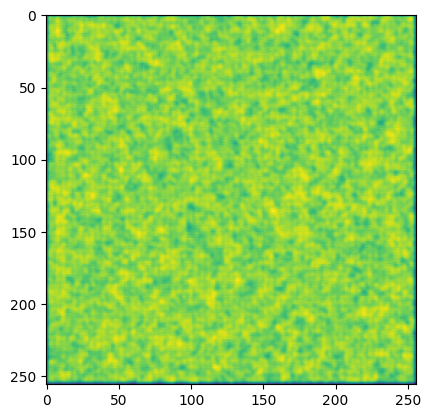

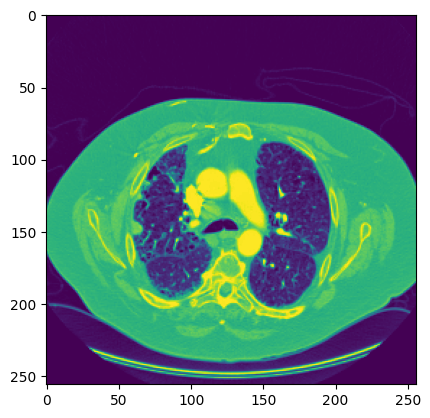

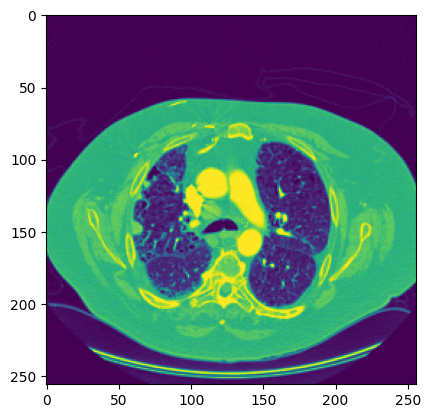

Validation loss: 721.4214477539062:   0%|          | 0/8 [00:00<?, ?batch/s]


In [48]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        # Define scaling factors
        big_scale = 1.01
        small_scale = 0.99

        # Scale the array
        recon = recon[0][0].cpu().numpy()
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

Validation loss: 744.765869140625:   0%|          | 0/8 [00:00<?, ?batch/s]

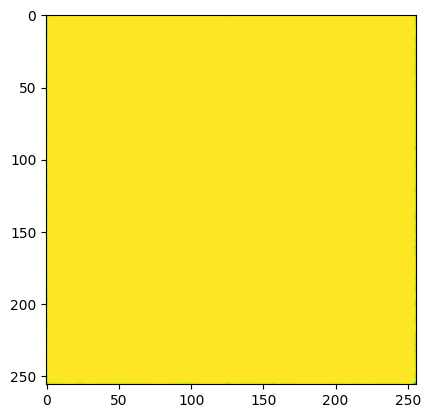

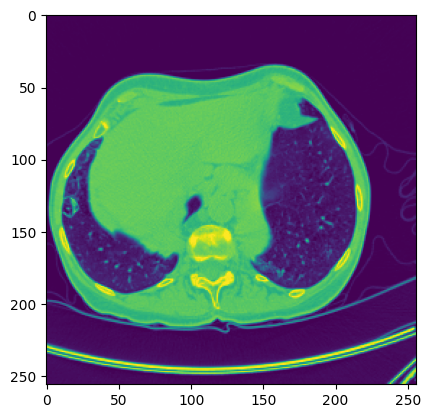

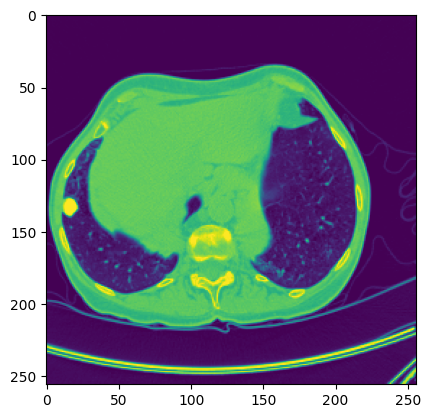

Validation loss: 744.765869140625:   0%|          | 0/8 [00:00<?, ?batch/s]


In [39]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

## Module 3: Prior UNet